In [93]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime

In [3]:
wego = pd.read_csv("../data/headway.csv")

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [3]:
wego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350329 entries, 0 to 350328
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CALENDAR_ID                350329 non-null  int64  
 1   SERVICE_ABBR               350329 non-null  int64  
 2   ADHERENCE_ID               350329 non-null  int64  
 3   DATE                       350329 non-null  object 
 4   ROUTE_ABBR                 350329 non-null  int64  
 5   BLOCK_ABBR                 350329 non-null  int64  
 6   OPERATOR                   350329 non-null  int64  
 7   TRIP_ID                    350329 non-null  int64  
 8   OVERLOAD_ID                350329 non-null  int64  
 9   ROUTE_DIRECTION_NAME       350329 non-null  object 
 10  TIME_POINT_ABBR            350329 non-null  object 
 11  ROUTE_STOP_SEQUENCE        350318 non-null  float64
 12  TRIP_EDGE                  350329 non-null  int64  
 13  LATITUDE                   35

In [4]:
wego.shape

(350329, 30)

In [13]:
wego['ROUTE_ABBR'].value_counts().sort_index()

ROUTE_ABBR
3     47162
7     18026
22    25959
23    42108
50    43291
52    51819
55    61944
56    60020
Name: count, dtype: int64

In [14]:
wego['SCHEDULED_TIME']=pd.to_datetime(wego['SCHEDULED_TIME'])

Headway is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop.

This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. Bunching occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. Gapping is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

Another important variable is adherence, which compares the actual departure time to the scheduled time and is included in the ADHERENCE column. A negative adherence value means that a bus left a time point late and a positive adherence indicates that the bus left the time point early. Buses with adherence values beyond negative 6 are generally considered late and beyond positive 1 are considered early. However, there is some additional logic where the staff applies waivers to allow early departures, such as an express bus that has already picked up everyone at a park-and-ride lot and is only dropping people off at the remaining stops, and also allows for early timepoint records for all records where TRIP_EDGE = 2 (end of trip), since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. Note: When determining whether a bus is early or late, it is advised that you use the 'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', and 'ADJUSTED_ONTIME_COUNT' columns in order to account for the adjustments.

#### Goals of this project:

1.) What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

    calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY

2.) How does direction of travel, route, or location affect the headway and on-time performance?

3.) How does time of day or day of week affect headway and on-time performance?

4.) How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

5.) Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [7]:
wego[[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
0,2023-08-01,120230801,345104,22,MHSP,1,2023-08-01 04:42:00,2023-08-01 04:44:08,-2.133333,0,0,1
1,2023-08-01,120230801,345104,22,ELIZ,0,2023-08-01 04:46:00,2023-08-01 04:48:27,-2.450000,0,0,1
2,2023-08-01,120230801,345104,22,CV23,0,2023-08-01 04:54:00,2023-08-01 04:54:56,-0.933333,0,0,1
3,2023-08-01,120230801,345104,22,MCC5_10,2,2023-08-01 05:10:00,2023-08-01 05:03:43,6.283333,0,0,1
4,2023-08-01,120230801,345105,22,MCC5_10,1,2023-08-01 05:15:00,2023-08-01 05:16:35,-1.583333,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
350324,2023-09-30,120230930,353448,7,21BK,0,2023-09-30 22:23:00,2023-09-30 22:31:26,-8.433333,0,1,0
350325,2023-09-30,120230930,353448,7,MCC5_9,2,2023-09-30 22:38:00,2023-09-30 22:49:18,-11.300000,0,1,0
350326,2023-09-30,120230930,353449,7,MCC5_9,1,2023-09-30 22:45:00,2023-09-30 22:49:19,-4.316666,0,0,1
350327,2023-09-30,120230930,353449,7,21BK,0,2023-09-30 22:59:00,2023-09-30 23:21:05,-22.083333,0,1,0


## overall on-time performance

In [22]:
(wego['ADJUSTED_ONTIME_COUNT'].sum()/350329)*100

#77% of all checkpoints are on time

77.08411236295025

## distribution of adherence

In [23]:
wego[['ADHERENCE']].apply(['min', 'max', 'mean', 'median'])

,ADHERENCE
min,-948.533333
max,88.383333
mean,-3.188796
median,-2.000000


In [8]:
wego['ADHERENCE'].describe()

count    338861.000000
mean         -3.188796
std           6.898842
min        -948.533333
25%          -4.566666
50%          -2.000000
75%          -0.333333
max          88.383333
Name: ADHERENCE, dtype: float64

[Text(0.5, 1.0, 'Adherence Distribution Excluding Outliers'),
 Text(0.5, 0, 'Adherence')]

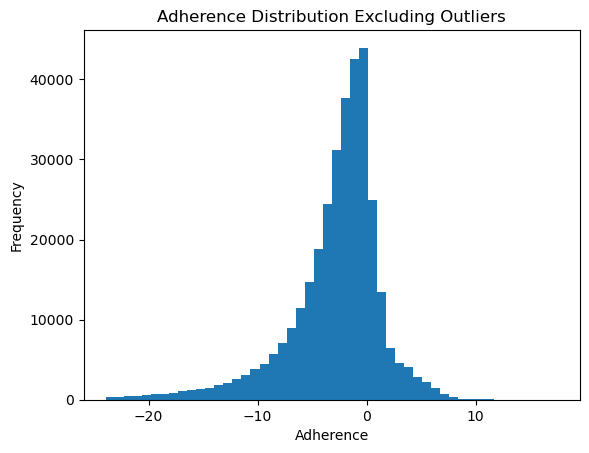

In [41]:
ad_mean = wego['ADHERENCE'].mean()
ad_std = np.std(wego['ADHERENCE'])
ax = (
    wego[wego['ADHERENCE'].between(ad_mean - ad_std*3,
                                   ad_mean + ad_std*3,
                                   inclusive='both')]
    ['ADHERENCE']
    .plot(kind='hist',
          bins=50)
)
ax.set(
    title='Adherence Distribution Excluding Outliers',
    xlabel='Adherence'
    )

## distribution of headway
    calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY


In [6]:
wego['HDWY_DEV'].describe()

count    265893.000000
mean          0.518081
std           7.161798
min         -64.000000
25%          -2.316667
50%           0.033333
75%           2.483333
max         565.433333
Name: HDWY_DEV, dtype: float64

[Text(0.5, 1.0, 'HDWY Distribution Excluding Outliers'), Text(0.5, 0, 'HDWY')]

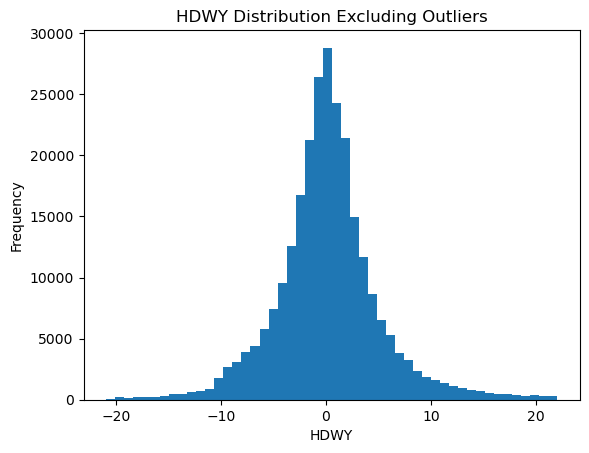

In [43]:
ad_mean = wego['HDWY_DEV'].mean()
ad_std = np.std(wego['HDWY_DEV'])
ax = (
    wego[wego['HDWY_DEV'].between(ad_mean - ad_std*3,
                                   ad_mean + ad_std*3,
                                   inclusive='both')]
    ['HDWY_DEV']
    .plot(kind='hist',
          bins=50)
)
ax.set(
    title='HDWY Distribution Excluding Outliers',
    xlabel='HDWY'
    )

Text(0.5, 1.0, 'Overall HDWY Distro')

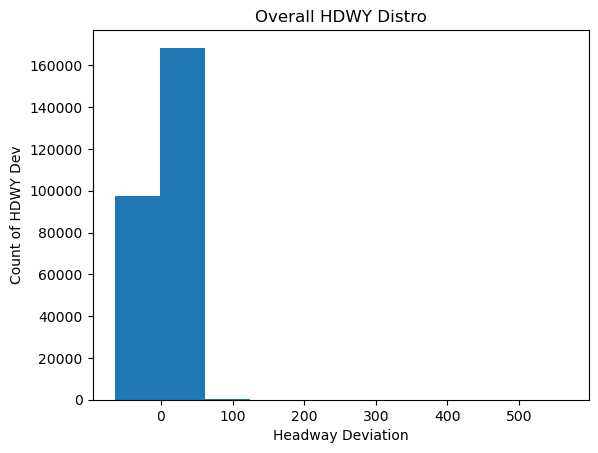

In [37]:
plt.hist(wego['HDWY_DEV'])
plt.xlabel("Headway Deviation")
plt.ylabel("Count of HDWY Dev")
plt.title("Overall HDWY Distro")

In [67]:
wego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350329 entries, 0 to 350328
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   CALENDAR_ID                350329 non-null  int64         
 1   SERVICE_ABBR               350329 non-null  int64         
 2   ADHERENCE_ID               350329 non-null  int64         
 3   DATE                       350329 non-null  object        
 4   ROUTE_ABBR                 350329 non-null  int64         
 5   BLOCK_ABBR                 350329 non-null  int64         
 6   OPERATOR                   350329 non-null  int64         
 7   TRIP_ID                    350329 non-null  int64         
 8   OVERLOAD_ID                350329 non-null  int64         
 9   ROUTE_DIRECTION_NAME       350329 non-null  object        
 10  TIME_POINT_ABBR            350329 non-null  object        
 11  ROUTE_STOP_SEQUENCE        350318 non-null  float64 

In [12]:
#calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY
(wego['HDWY_DEV'].sum()/wego['SCHEDULED_HDWY'].sum())*100

2.757072953617922

# Q2.) How does direction of travel, route, or location affect the headway and on-time performance?


In [96]:
direction = wego[['ROUTE_DIRECTION_NAME',"ADJUSTED_LATE_COUNT", 'ADJUSTED_EARLY_COUNT','ADJUSTED_ONTIME_COUNT','ROUTE_ABBR']].groupby(['ROUTE_DIRECTION_NAME','ROUTE_ABBR']).sum(['ADJUSTED_EARLY_COUNT','ADJUSTED_ONTIME_COUNT','ADJUSTED_LATE_COUNT'])
direction


ADJUSTED_LATE_COUNT  ADJUSTED_EARLY_COUNT  \
ROUTE_DIRECTION_NAME ROUTE_ABBR                                              
FROM DOWNTOWN        3                          6680                   639   
                     7                          2186                   298   
                     22                         1538                   373   
                     23                         2496                   629   
                     50                         2803                   661   
                     52                         7092                   882   
                     55                         9843                   803   
                     56                         6963                  1006   
TO DOWNTOWN          3                          2910                   743   
                     7                          1231                   135   
                     22                          527                   258   
                     23                          734                   657   
                     50                         2310                   546   
                     52                         2946                   671   
                     55                         6905                   728   
                     56                         1874                   746   

                                 ADJUSTED_ONTIME_COUNT  
ROUTE_DIRECTION_NAME ROUTE_ABBR                         
FROM DOWNTOWN        3                           15447  
                     7                            6542  
                     22                          11008  
                     23                          20646  
                     50                          17788  
                     52                          17399  
                     55                          19233  
                     56                          26351  
TO DOWNTOWN          3                           19069  
                     7                            6875  
                     22                          11484  
                     23                          14491  
                     50                          18521  
                     52                          20337  
                     55                          22847  
                     56                          22010

In [97]:
direction = direction.rename(columns = {'ADJUSTED_LATE_COUNT':'late_total',
                                       'ADJUSTED_EARLY_COUNT': 'early_total',
                                       'ADJUSTED_ONTIME_COUNT': 'ontime_total'})
direction

late_total  early_total  ontime_total
ROUTE_DIRECTION_NAME ROUTE_ABBR                                       
FROM DOWNTOWN        3                 6680          639         15447
                     7                 2186          298          6542
                     22                1538          373         11008
                     23                2496          629         20646
                     50                2803          661         17788
                     52                7092          882         17399
                     55                9843          803         19233
                     56                6963         1006         26351
TO DOWNTOWN          3                 2910          743         19069
                     7                 1231          135          6875
                     22                 527          258         11484
                     23                 734          657         14491
                     50                2310          546         18521
                     52                2946          671         20337
                     55                6905          728         22847
                     56                1874          746         22010

In [98]:
direction['%on_time'] = direction['ontime_total']/(direction['ontime_total']+direction['late_total']+direction['early_total'])*100
direction

late_total  early_total  ontime_total  \
ROUTE_DIRECTION_NAME ROUTE_ABBR                                          
FROM DOWNTOWN        3                 6680          639         15447   
                     7                 2186          298          6542   
                     22                1538          373         11008   
                     23                2496          629         20646   
                     50                2803          661         17788   
                     52                7092          882         17399   
                     55                9843          803         19233   
                     56                6963         1006         26351   
TO DOWNTOWN          3                 2910          743         19069   
                     7                 1231          135          6875   
                     22                 527          258         11484   
                     23                 734          657         14491   
                     50                2310          546         18521   
                     52                2946          671         20337   
                     55                6905          728         22847   
                     56                1874          746         22010   

                                  %on_time  
ROUTE_DIRECTION_NAME ROUTE_ABBR             
FROM DOWNTOWN        3           67.851182  
                     7           72.479504  
                     22          85.207833  
                     23          86.853729  
                     50          83.700358  
                     52          68.572892  
                     55          64.369624  
                     56          76.780303  
TO DOWNTOWN          3           83.923070  
                     7           83.424342  
                     22          93.601761  
                     23          91.241657  
                     50          86.639847  
                     52          84.900225  
                     55          74.957349  
                     56          89.362566

In [103]:
plt.hist(direction.ROUTE_ABBR, direction.ontime_total)

AttributeError: 'DataFrame' object has no attribute 'ROUTE_ABBR'

In [101]:
headway = wego[['ROUTE_DIRECTION_NAME','ROUTE_ABBR','ACTUAL_HDWY']].groupby(['ROUTE_DIRECTION_NAME','ROUTE_ABBR']).agg(['min', 'max', 'mean'])
headway

ACTUAL_HDWY                       
                                        min         max       mean
ROUTE_DIRECTION_NAME ROUTE_ABBR                                   
FROM DOWNTOWN        3             0.000000  391.866666  18.641661
                     7             0.050000   95.416666  23.338300
                     22            0.000000  558.700000  27.289011
                     23            0.016666  590.433333  20.496135
                     50            0.016666   70.500000  19.831437
                     52            0.000000  304.383333  19.713565
                     55            0.000000   83.000000  13.993384
                     56            0.000000  176.000000  14.178556
TO DOWNTOWN          3             0.000000  129.916666  21.627054
                     7             0.050000   73.516666  22.978687
                     22            0.066666  268.983333  34.276775
                     23            0.066666  568.833333  17.523705
                     50            0.016666   84.283333  19.675972
                     52            0.016666  514.366666  22.078139
                     55            0.000000  122.000000  13.725681
                     56            0.000000   69.616666  14.128893

### Q2 Answer: directions from downtown is ontime less than to downtown

# Q3.) How does time of day or day of week affect headway and on-time performance?


In [88]:
wego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350329 entries, 0 to 350328
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   CALENDAR_ID                350329 non-null  int64         
 1   SERVICE_ABBR               350329 non-null  int64         
 2   ADHERENCE_ID               350329 non-null  int64         
 3   DATE                       350329 non-null  object        
 4   ROUTE_ABBR                 350329 non-null  int64         
 5   BLOCK_ABBR                 350329 non-null  int64         
 6   OPERATOR                   350329 non-null  int64         
 7   TRIP_ID                    350329 non-null  int64         
 8   OVERLOAD_ID                350329 non-null  int64         
 9   ROUTE_DIRECTION_NAME       350329 non-null  object        
 10  TIME_POINT_ABBR            350329 non-null  object        
 11  ROUTE_STOP_SEQUENCE        350318 non-null  float64 

In [90]:
wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [94]:
#date to weekday
time = wego['DATE'].dt.week

AttributeError: Can only use .dt accessor with datetimelike values